<center> 
    <h1> 
        Project Machine Learning for Natural Language Proccessing - April 2021
    <h2> 
        ENSAE 3e année - Cycle Ingénieur

<center>
<img src="https://drive.google.com/uc?id=11e9TZk9co2fqaHFq8RJkQ3ggzyPgVNBW" width="200px">

 <center>
    <h2> 
        Fake News Detection

<div style="text-align: right">
    <em>
        Authors : Billiot Bastien - Rémy Deshayes <br>
        Professors : Benjamin Muller and Gaël Guibon <br>
        Link to the <a href="https://www.uvic.ca/engineering/ece/isot/datasets/fake-news/index.php"> ISOT Fake News dataset </a> that will be used in this notebook. 
    </em>
</div>

# 0. Imports 

We begin by first importing a few libraries that we will need in our studies : some standards librairies and some that we will use more specifically for NLP matters. 

In [ ]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns

import re
from tqdm.notebook import tqdm
from datetime import datetime
from functools import reduce
from operator import add
from collections import Counter

import nltk
from nltk.tokenize import TreebankWordTokenizer, TweetTokenizer
nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords = list(set(stopwords.words('english')))
from gensim.models.phrases import Phrases, Phraser
from string import punctuation
punctuation = list(punctuation)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
#from google.colab import drive
#drive.mount("/content/drive/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# 1. Datasets first pre-proceessing

## 1.1. Verified news dataset

We begin by loading our datasets of news. As a reminder both datasets that we will use can be found [here](https://www.uvic.ca/engineering/ece/isot/datasets/fake-news/index.php)

In [ ]:
! wget https://raw.githubusercontent.com/Bastienbbil/Deep-Learning-NLP-Pytorch/main/True.csv
true_raw = pd.read_csv("True.csv")
print('Size of true dataset:', true_raw.shape)
true_raw.head()

--2021-04-24 17:08:35--  https://raw.githubusercontent.com/Bastienbbil/Deep-Learning-NLP-Pytorch/main/True.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53561522 (51M) [text/plain]
Saving to: ‘True.csv’

True.csv            100%[===================>]  51.08M  76.4MB/s    in 0.7s    

2021-04-24 17:08:36 (76.4 MB/s) - ‘True.csv’ saved [53561522/53561522]

Size of true dataset: (21417, 4)


,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


As we can see our verified news is composed of four features : the title of the article, the textual content of the article, the subject it covers and the date when the article was published. 

We begin by checking whether we have nan values in this dataset

In [ ]:
true_raw.isna().sum()

title      0
text       0
subject    0
date       0
dtype: int64

### 1.1.1. Text column

As we can see, it seems that all verified news have the tendency to begin with the format "*CITY* (Reuters) -" We will check that by looking at the most recurrent word in this dataset  

In [ ]:
def most_common(corpus, nb_words):
  """
  Returns the chosen number of most common words in our corpus
  with their occurences number
  ------------
  Inputs : 
    corpus(pd.Series) : the corpus containing the text samples
    nb_words (int) : number of most common words to return 
  Outputs : 
    d[:nb_words] (pd.DataFrame) : most common words and their occurances in the corpus
  """
  articles = corpus.str.split()
  words = np.array([word for article in articles for word in article if word.lower() not in stopwords])
  counter = Counter(words)
  d = pd.DataFrame(counter, index=['occurrences']).transpose().reset_index()
  d.columns=['word', 'occurences']
  d = d.sort_values('occurences', ascending=False)
  return d[:nb_words]

In [ ]:
most_common(true_raw['text'], 10)

,word,occurences
113,said,72025
7,U.S.,38271
73,Trump,36461
162,would,31330
2,-,31059
136,said.,21582
1,(Reuters),21239
71,President,17112
79,also,15703
164,United,15030


Indeed, as we can see the occurences "(Reuters)" and "-" are quite frequent, thus we propose to delete the pattern "CITY (Reuter) -" when it is present in the first 50 characters of an article. Without this cleaning, the pattern of verified news would constitute a bias for the predictive system. 

In [ ]:
for i in range(0, len(true_raw['text'])): 
  try : 
    start = re.search('(Reuters)',true_raw['text'][i][0:49]).end() + 3
  except : 
    pass
  true_raw['text'][i] = true_raw['text'][i][start:]

In [ ]:
true_raw.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",The head of a conservative Republican faction...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,Transgender people will be allowed for the fi...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,The special counsel investigation of links be...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,Trump campaign adviser George Papadopoulos to...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,President Donald Trump called on the U.S. Pos...,politicsNews,"December 29, 2017"


Once done, we check if we have any duplicates or blanck article (only spaces) or anything abnormal. 

In [ ]:
true_raw['text'].value_counts()[true_raw['text'].value_counts()>1]

 Highlights for U.S. President Donald Trump’s administration on Thursday: The United States drops a massive GBU-43 bomb, the largest non-nuclear bomb it has ever used in combat, in Afghanistan against a series of caves used by Islamic State militants, the Pentagon says. Trump says Pyongyang is a problem that “will be taken care of” amid speculation that North Korea is on the verge of a sixth nuclear test. Military force cannot resolve tension over North Korea, China warns, while an influential Chinese newspaper urges Pyongyang to halt its nuclear program in exchange for Beijing’s protection. The Trump administration is focusing its North Korea strategy on tougher economic sanctions, possibly including intercepting cargo ships and punishing Chinese banks doing business with Pyongyang, U.S. officials say. Trump says “things will work out fine” between the United States and Russia, a day after declaring U.S.-Russian relations may be at an all-time low. Trump signals he could be moving clo

In [ ]:
true_raw['text'].value_counts()[true_raw['text'].value_counts()>1].sum() - 211

224

As we can see, we have a few duplicates that we have to delete (we later drop the date thus justifying deletion of duplicates when the same article is published at two different dates).



In [ ]:
true_raw = true_raw.drop_duplicates(subset=['text'], ignore_index=True)

In [ ]:
true_raw.shape

(21193, 4)

Next step, we will simply add title and text column in the same column

In [ ]:
true_raw['article'] = true_raw['title'] + '.' + true_raw['text']

In [ ]:
true_raw['article'][0]

'As U.S. budget fight looms, Republicans flip their fiscal script. The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fiscal conservative” on Sunday and urged budget restraint in 2018. In keeping with a sharp pivot under way among Republicans, U.S. Representative Mark Meadows, speaking on CBS’ “Face the Nation,” drew a hard line on federal spending, which lawmakers are bracing to do battle over in January. When they return from the holidays on Wednesday, lawmakers will begin trying to pass a federal budget in a fight likely to be linked to other issues, such as immigration policy, even as the November congressional election campaigns approach in which Republicans will seek to keep control of Congress. President Donald Trump and his Republicans want a big budget increase in military spending, while Democrats also want proportional increases for non-defense “discretionar

In [ ]:
del true_raw['title']
del true_raw['text']

In [ ]:
true_raw.head()

,subject,date,article
0,politicsNews,"December 31, 2017","As U.S. budget fight looms, Republicans flip t..."
1,politicsNews,"December 29, 2017",U.S. military to accept transgender recruits o...
2,politicsNews,"December 31, 2017",Senior U.S. Republican senator: 'Let Mr. Muell...
3,politicsNews,"December 30, 2017",FBI Russia probe helped by Australian diplomat...
4,politicsNews,"December 29, 2017",Trump wants Postal Service to charge 'much mor...


### 1.1.2. Date column

We will check the length of each date value to check whether all data format are uniform.

In [ ]:
true_raw['date_len'] = [len(x) for x in true_raw['date']]
print(true_raw['date_len'].value_counts())
del true_raw['date_len']

17    6262
18    5703
19    2495
14    2010
16    1699
15    1617
13    1183
12     224
Name: date_len, dtype: int64


It seems that it is the case so now, we decide to unify the date format to datetime. 

In [ ]:
dates = []
for x in true_raw['date']: 
  date = datetime.strptime(x,'%B %d, %Y ')
  dates.append(date)
true_raw['date'] = dates

Finally, as we will deal later with the subject, we create a label variable 

In [ ]:
true_raw['label'] = 1

## 1.2. Fake news dataset

In [ ]:
! wget https://raw.githubusercontent.com/Bastienbbil/Deep-Learning-NLP-Pytorch/main/Fake.csv
fake_raw = pd.read_csv("Fake.csv")
print('Size of fake dataset:', fake_raw.shape)
fake_raw.head()

--2021-04-24 17:08:44--  https://raw.githubusercontent.com/Bastienbbil/Deep-Learning-NLP-Pytorch/main/Fake.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 62789876 (60M) [text/plain]
Saving to: ‘Fake.csv’

Fake.csv            100%[===================>]  59.88M   105MB/s    in 0.6s    

2021-04-24 17:08:45 (105 MB/s) - ‘Fake.csv’ saved [62789876/62789876]

Size of fake dataset: (23481, 4)


,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


As we can see, we have the same original features in the fake news as in the formerly handled verified news dataset : title, textual content, subject covered and date of publication. Once again, let's look at nan potential values. 


In [ ]:
fake_raw.isna().sum()

title      0
text       0
subject    0
date       0
dtype: int64

### 1.2.1. Text column

As for verified news, we will inspect our duplicates. 


In [ ]:
duplicates = fake_raw['text'].value_counts()[fake_raw['text'].value_counts()>1]

In [ ]:
duplicates

As we can see it seems that we have several duplicates. The most striking is the presence of 626 articles which are blank. Let's get rid of both duplicates and blank articles. 

In [ ]:
fake_raw.drop(fake_raw[fake_raw['text'] == duplicates.index.tolist()[0]].index, inplace=True)
fake_raw = fake_raw.drop_duplicates(subset=['text'], ignore_index=True)

In [ ]:
fake_raw.shape

(17454, 4)

In [ ]:
fake_raw['article'] = fake_raw['title'] + '.' + fake_raw['text']
del fake_raw['title']
del fake_raw['text']

### 1.2.2. Date column

In [ ]:
fake_raw['date_len'] = [len(x) for x in fake_raw['date']]
print(fake_raw['date_len'].value_counts())

12     6470
11     2474
16     2020
13     1722
17     1634
14     1622
15     1020
18      451
9        35
74        1
120       1
88        1
149       1
66        1
145       1
Name: date_len, dtype: int64


We can see that all dates are not in a proper date format and moreover abnormally long strings raise concerns on whether or not the considered string is indeed a date. We will look at the dates whose length is particularly abnormal : below 10 and above 18 length. 

In [ ]:
print(fake_raw[fake_raw['date_len']<10]['date'])

9050    19-Feb-18
9051    19-Feb-18
9052    19-Feb-18
9053    18-Feb-18
9054    18-Feb-18
9055    18-Feb-18
9056    18-Feb-18
9057    18-Feb-18
9058    18-Feb-18
9059    18-Feb-18
9060    17-Feb-18
9061    17-Feb-18
9062    17-Feb-18
9063    17-Feb-18
9064    17-Feb-18
9065    17-Feb-18
9066    17-Feb-18
9067    16-Feb-18
9068    16-Feb-18
9069    16-Feb-18
9070    16-Feb-18
9071    16-Feb-18
9072    16-Feb-18
9073    16-Feb-18
9074    16-Feb-18
9075    15-Feb-18
9076    15-Feb-18
9077    15-Feb-18
9078    15-Feb-18
9079    15-Feb-18
9080    15-Feb-18
9081    15-Feb-18
9082    15-Feb-18
9083    15-Feb-18
9084    14-Feb-18
Name: date, dtype: object


As we can see, there is nothing wrong with dates of format whose length is of 9, it shows nonetheless that all of our dates in the fake dataset are not in the same format and we will have to take all formats into account. 

In [ ]:
print(fake_raw[fake_raw['date_len']>18]['date'])
del fake_raw['date_len']

9357     https://100percentfedup.com/served-roy-moore-v...
15120    https://100percentfedup.com/video-hillary-aske...
15121    https://100percentfedup.com/12-yr-old-black-co...
15423    https://fedup.wpengine.com/wp-content/uploads/...
15424    https://fedup.wpengine.com/wp-content/uploads/...
16127    MSNBC HOST Rudely Assumes Steel Worker Would N...
Name: date, dtype: object


However, we note that dates whose value length is longer than 18 is wrongly entered with URLs values and a textual value that we will delete now. We decide to delete rows whose date is not valid as dates can be used to predict whether news are fake or true. Another possibility if we don't take dates as a feature would be to simply delete the column. 

In [ ]:
indexes = []
pattern = 'http'
pattern_1 = 'MSNBC'
for x in fake_raw['date']:
  if re.search(pattern, x):
    ind = np.where(fake_raw['date'] == x)
    (liste,) = ind
    indexes.append(liste.tolist())
  elif re.search(pattern_1, x):
    ind = np.where(fake_raw['date'] == x)
    (liste,) = ind
    indexes.append(liste.tolist())
indexes_ = [element for liste in indexes for element in liste]
indexes = list(dict.fromkeys(indexes_))
fake_raw = fake_raw.drop(index=indexes)

In [ ]:
indexes

[9357, 15120, 15121, 15423, 15424, 16127]

Now that we only have genuine dates in our dataset, we choose to unify them under a unique datetime format for the sake of simplicity. 

In [ ]:
dates = []
for x in fake_raw['date']: 
  try : 
    date = datetime.strptime(x, '%B %d, %Y')
  except ValueError:
    try : 
      date = datetime.strptime(x, '%d-%b-%y')
    except ValueError:
      date = datetime.strptime(x, '%b %d, %Y')
  dates.append(date)
fake_raw['date'] = dates

In [ ]:
fake_raw['date'].nunique

<bound method IndexOpsMixin.nunique of 0       2017-12-31
1       2017-12-31
2       2017-12-30
3       2017-12-29
4       2017-12-25
           ...    
17449   2016-01-07
17450   2016-01-07
17451   2016-01-06
17452   2016-01-04
17453   2016-01-02
Name: date, Length: 17448, dtype: datetime64[ns]>

All dates of fake news are now in the same date format.

In [ ]:
fake_raw['label'] = 0

## 1.3. Concatenation

In [ ]:
dataset = pd.concat([true_raw, fake_raw])
dataset.reset_index(drop=True, inplace=True)
print(dataset.shape)
dataset.head()

(38641, 4)


,subject,date,article,label
0,politicsNews,2017-12-31,"As U.S. budget fight looms, Republicans flip t...",1
1,politicsNews,2017-12-29,U.S. military to accept transgender recruits o...,1
2,politicsNews,2017-12-31,Senior U.S. Republican senator: 'Let Mr. Muell...,1
3,politicsNews,2017-12-30,FBI Russia probe helped by Australian diplomat...,1
4,politicsNews,2017-12-29,Trump wants Postal Service to charge 'much mor...,1


# 2. Explanatory Analysis

### 2.1. Subject column

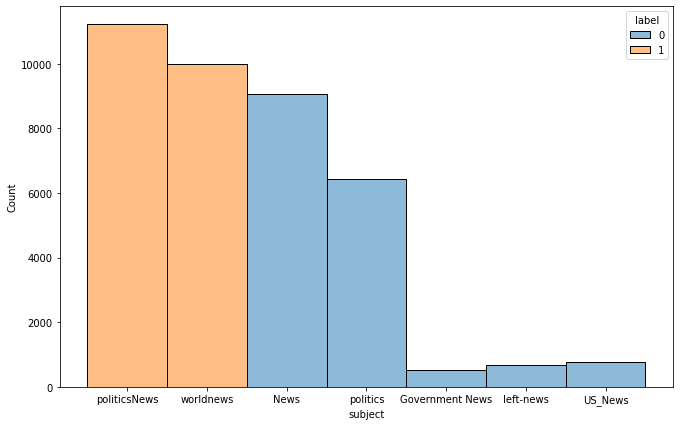

In [ ]:
fig, hist = plt.subplots(figsize = (11,7))
hist = sns.histplot(data=dataset, x = 'subject', hue="label")

In [ ]:
del dataset['subject']

As we can see, subjects are not shared between the two datasets. Considering this raw columns as an inupt feature could thus drive the model to simply use it and directly classify our samples. Thus we decide to delete it and not take it into account. 

An alternative way could consider the following ideas : either we have ressources to get our articles labelled or we can also try to implement a topic modelling model on our articles and pass then the most present topic detected by the model as a feature. 

### 2.2. Date column

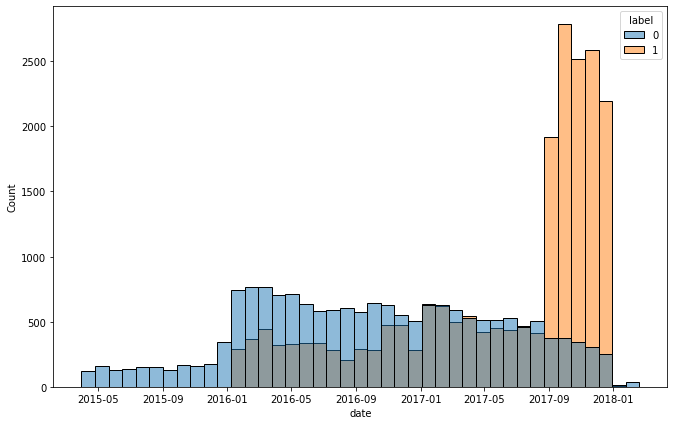

In [ ]:
fig, hist = plt.subplots(figsize = (11,7))
hist = sns.histplot(data=dataset, x = 'date', hue="label")

In [ ]:
del dataset['date']

As we can see on the above graph, the articles between fake and true news seem not to have all been published at the same dates. Indeed, in our dataset, we have only fake news published before 2016. Then we have periods where both fake and true news. Indeed, we then have two solutions. The first one would be to drop the articles published before 2016 to prevent the model from learning from it. we can also see that afterwards, the dates are rather inequally distributed. We decide more simply to drop the date column and not use it as a feature even if an alternative model could consider it.

### 2.3. Text analysis and pre-processing

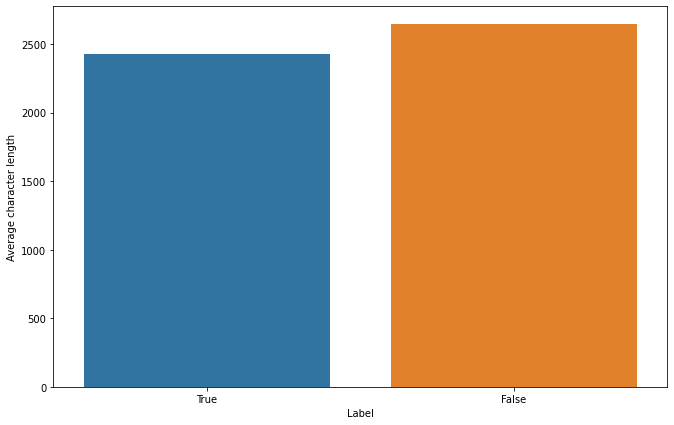

In [ ]:
av_t = dataset[dataset['label'] == 1]['article'].apply(lambda x: len(x)).mean()
av_f = dataset[dataset['label'] == 0]['article'].apply(lambda x: len(x)).mean()
av = pd.DataFrame(data = {'Average character length': [av_t, av_f], 'Label':['True', 'False']})
fig, bar = plt.subplots(figsize = (11,7))
bar = sns.barplot(y='Average character length', x='Label',data=av, )

We can see that there is no striking difference between fake and true news for the average character length.

Text(0.5, 1.0, 'False texts')

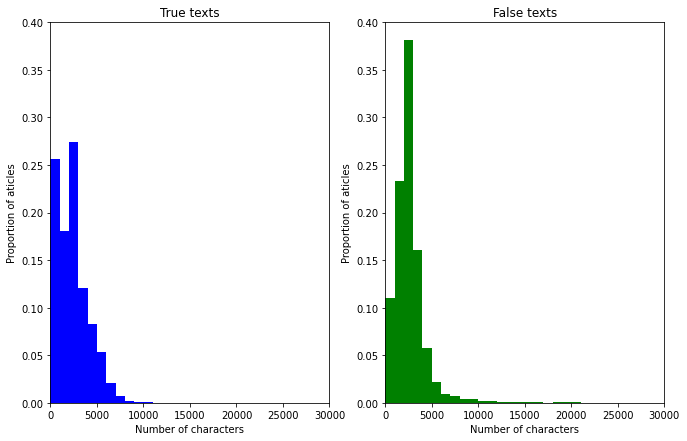

In [ ]:
# Characters length of articles
len_cha_true = dataset[dataset['label'] == 1]['article'].apply(lambda x: len(x))
len_cha_false = dataset[dataset['label'] == 0]['article'].apply(lambda x: len(x))

bins_ = [i * 1000 for i in range(0,31)]

fig, (hist1, hist2) = plt.subplots(1,2, figsize = (11,7))
hist1.hist(len_cha_true, bins = bins_, weights = np.ones(len(len_cha_true))/len(len_cha_true), color = 'b')
hist1.set_ylim(0, top=0.4)
hist1.set_xlim(0, 30000)
hist1.set_xlabel('Number of characters')
hist1.set_ylabel('Proportion of aticles')
hist1.set_title('True texts')

hist2.hist(len_cha_false, bins = bins_, weights = np.ones(len(len_cha_false))/len(len_cha_false), color = 'g')
hist2.set_ylim(0, top=0.4)
hist2.set_xlim(0, 30000)
hist2.set_xlabel('Number of characters')
hist2.set_ylabel('Proportion of aticles')
hist2.set_title('False texts')

Here again, we have no striking difference in the number of charcters : both fake and true news have most of the time less than 5000 charcters. However, we can note that fake news articles have a peak between 2000 and 3000 characters compared to true news. 

Text(0.5, 1.0, 'False texts')

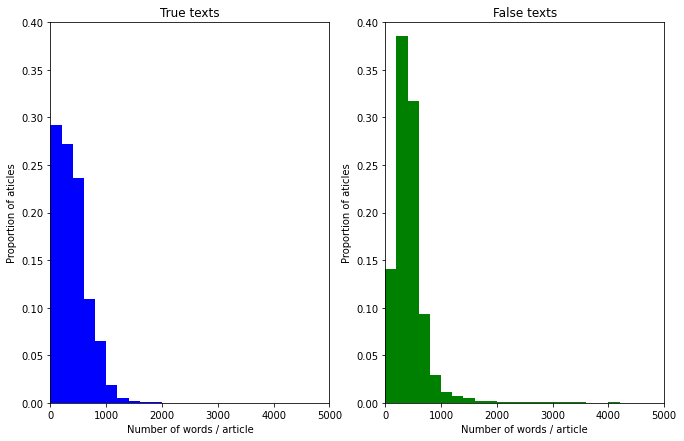

In [ ]:
# Number of words per article
len_w_true = dataset[dataset['label'] == 1]['article'].str.split().map(lambda x: len(x))
len_w_false = dataset[dataset['label'] == 0]['article'].str.split().map(lambda x: len(x))


bins_ = [i * 200 for i in range(0,26)]

fig, (hist1, hist2) = plt.subplots(1,2, figsize = (11,7))
hist1.hist(len_w_true, bins = bins_, weights = np.ones(len(len_w_true))/len(len_w_true), color = 'b')
hist1.set_ylim(0, top=0.4)
hist1.set_xlim(0, 5000)
hist1.set_xlabel('Number of words / article')
hist1.set_ylabel('Proportion of aticles')
hist1.set_title('True texts')
hist2.hist(len_w_false, bins = bins_, weights = np.ones(len(len_w_false))/len(len_w_false), color = 'g')
hist2.set_ylim(0, top=0.4)
hist2.set_xlim(0, 5000)
hist2.set_xlabel('Number of words / article')
hist2.set_ylabel('Proportion of aticles')
hist2.set_title('False texts')

We then proceed to a first cleaning of our articles. As we saw with some data exploration, we have a few html tags, urls, hastags and @ coming from tweets and square brackets (especially in the fake news dataset). We also decided to remove the stopwords and the punctuation from our articles.

In [ ]:
stop = stopwords + punctuation + ['“','’', '“', '”', '‘','...']
tqdm.pandas()

def lowerizer(article):
  """
  Lowerize a given text
  ----
  Inputs : 
    article (str) : text to be pre-processed
  Outputs : 
    article.lower() (str) : lowerized text
  """
  return article.lower()

def remove_html(article):
    """
    Remove HTML tags from a given text
    ----
    Inputs : 
      article (str) : text to be pre-processed
    Outputs : 
      article (str) : text cleaned of HTML tags
    """
    article = re.sub("(<!--.*?-->)", "", article, flags=re.DOTALL)
    return article

def remove_url(article):
    """
    Remove URL tags from a given text
    ----
    Inputs : 
      article (str) : text to be pre-processed
    Outputs : 
      article (str) : text cleaned of URL tags
    """
    article = re.sub(r'https?:\/\/.\S+', "", article)
    return article

def remove_hashtags(article):
    """
    Remove hashtags from a given text
    ----
    Inputs : 
      article (str) : text to be pre-processed
    Outputs : 
      article (str) : text cleaned of hashtags
    """
    article = re.sub("#"," ",article)
    return article

def remove_a(article):
    """
    Remove twitter account references @ rom a given text
    ----
    Inputs : 
      article (str) : text to be pre-processed
    Outputs : 
      article (str) : text withouttwitter account references 
    """
    article = re.sub("@"," ",article)
    return article

def remove_brackets(article):
    """
    Remove square brackets from a given text 
    ----
    Inputs : 
      article (str) : text to be pre-processed
    Outputs : 
      article (str) : text without square brackets
    """
    article = re.sub('\[[^]]*\]', '', article)
    return article

def remove_stop_punct(article):
    """
    Remove punctuation and stopwords from a given text
    ----
    Inputs : 
      article (str) : text to be pre-processed
    Outputs : 
      article (str) : text without punctuation or stopwords
    """
    final_article = []
    for i in article.split():
        if i not in stop:
            final_article.append(i.strip())
    return " ".join(final_article)

def preprocessing(article):
    """
    Computes the above-define steps to clean a given text
    ----
    Inputs : 
      article (str) : text to be pre-processed
    Outputs : 
      article (str) : pre-processed text
    """
    article = lowerizer(article)
    article = remove_html(article)
    article = remove_url(article)
    article = remove_hashtags(article)
    article = remove_a(article)
    article = remove_brackets(article)
    article = remove_stop_punct(article)
    return article

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [ ]:
dataset['article_clean'] = dataset['article'].progress_apply(lambda x : preprocessing(x))

In [ ]:
dataset

,article,label,article_clean
0,"As U.S. budget fight looms, Republicans flip t...",1,"u.s. budget fight looms, republicans flip fisc..."
1,U.S. military to accept transgender recruits o...,1,u.s. military accept transgender recruits mond...
2,Senior U.S. Republican senator: 'Let Mr. Muell...,1,senior u.s. republican senator: 'let mr. muell...
3,FBI Russia probe helped by Australian diplomat...,1,fbi russia probe helped australian diplomat ti...
4,Trump wants Postal Service to charge 'much mor...,1,trump wants postal service charge 'much more' ...
...,...,...,...
38636,The White House and The Theatrics of ‘Gun Cont...,0,white house theatrics ‘gun control’.21st centu...
38637,Activists or Terrorists? How Media Controls an...,0,activists terrorists? media controls dictates ...
38638,"BOILER ROOM – No Surrender, No Retreat, Heads ...",0,"boiler room – surrender, retreat, heads roll –..."
38639,Federal Showdown Looms in Oregon After BLM Abu...,0,federal showdown looms oregon blm abuse local ...


Lastly, we plot a few visual data presentation graphs : wordclouds for true and fake news to visually see the most frequent words as well as unigrams and bigrams for true and fake datasets to see these occurences.

In [ ]:
from wordcloud import WordCloud,STOPWORDS
def wordcloud(corpus, title): 
  wordcloud = WordCloud(width = 1000, height = 500, stopwords=STOPWORDS, background_color='white').generate(" ".join(corpus))
  plt.figure(figsize=(15,8))
  plt.imshow(wordcloud)
  plt.title(title)
  plt.axis("off")
  plt.show()

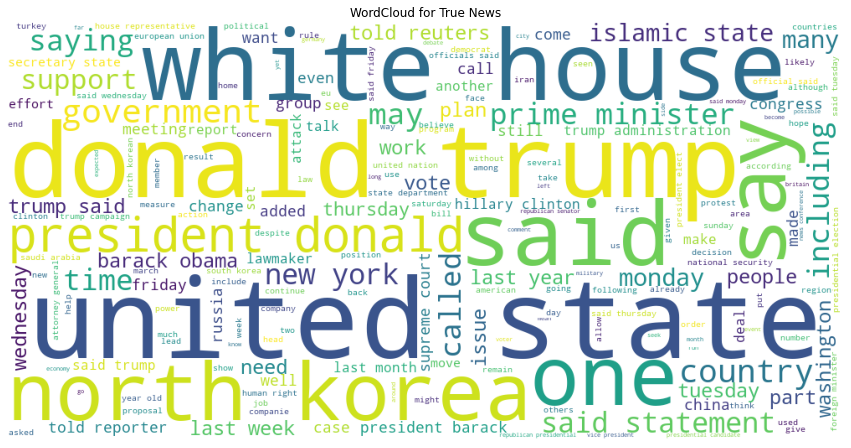

In [ ]:
wordcloud(dataset[dataset['label']==1]['article_clean'], "WordCloud for True News")

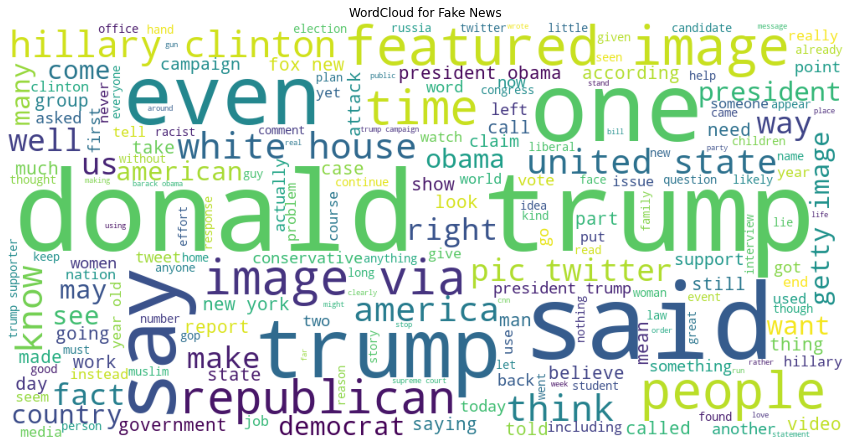

In [ ]:
wordcloud(dataset[dataset['label']==0]['article_clean'], "WordCloud for Fake News")

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
def get_ngrams(corpus, nb_grams, nb_words):
    """
    Computes and return the chosen most n_grams of a corpus 
    ----
    Inputs : 
      corpus(pd.Serie) : given corpus of texts
      n (int) :  number of n_grams to dislay(most frequent)
      g (int) : number of n_grams
    Outputs : 
      article (str) : pre-processed text
    """
    count = CountVectorizer(ngram_range=(nb_grams, nb_grams)).fit(corpus)
    ensemble = count.transform(corpus).sum(axis=0)
    words_freq = [(word, ensemble[0, idx]) for word, idx in count.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:nb_words]

In [ ]:
def plot_ngrams(get_top_text_ngrams_output, title, n, num_to_show=20):
  """
  Returns a line plot with occurence count on the absciss and num_to_show most frequent int_n-grams on the ordinate
  ------------
  Inputs : 
    get_top_text_ngrams_output(list of tuples) : list containing the most frequent n-grams and their occurrences
    title (str) : titre du graphique
    n (int) : bigrams (2), trigrams (3), etc.
    num_to_show (int) : number of most common words to return 
  Outputs : 
    matplotlib line plot : most common n-grams and their occurrences in the corpus
  """
  df = pd.DataFrame(get_top_text_ngrams_output, columns=['ngram', 'count'])
    
  counts, word = df['count'], df['ngram']
  zipped_lists = zip(counts, word)
  sorted_pairs = sorted(zipped_lists)

  tuples = zip(*sorted_pairs)
  counts, word = [ list(tuple) for tuple in  tuples]

  plt.figure(figsize=[6,10])
  plt.plot(counts[-num_to_show:], word[-num_to_show:],lw=5,c='b')
  plt.ylabel('{}-grams'.format(n),fontsize=20)
  plt.yticks(fontsize=14)
  plt.xlabel('Occurrence count',fontsize=20)
  plt.xticks(fontsize=14)
  plt.show()

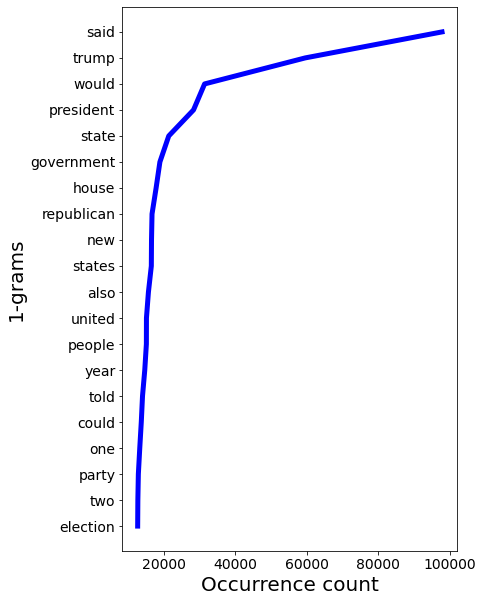

In [ ]:
b = get_ngrams(dataset[dataset['label']==1]['article_clean'],1,20)
plot_ngrams(b,"Unigram for True News" , 1, num_to_show=20)

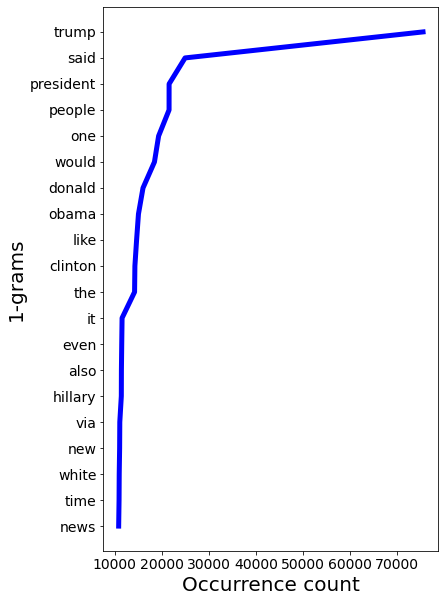

In [ ]:
b = get_ngrams(dataset[dataset['label']==0]['article_clean'],1,20)
plot_ngrams(b,"Unigram for Fake News", 1, num_to_show=20)

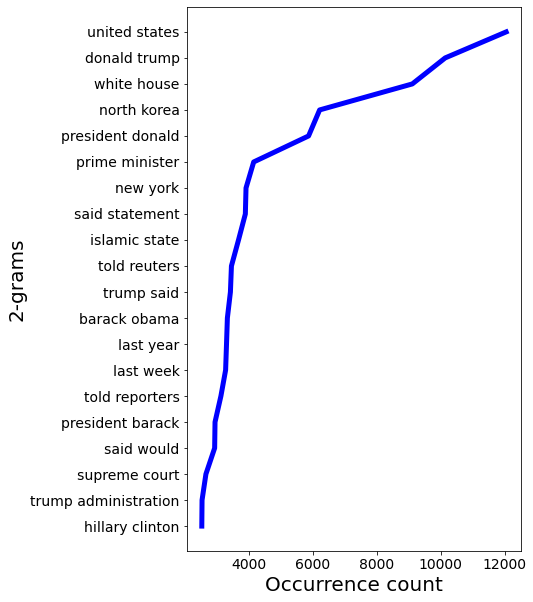

In [ ]:
# label is 1
b = get_ngrams(dataset[dataset['label']==1]['article_clean'],2,20)
plot_ngrams(b,"Bigrams for True News", 2, num_to_show=20)

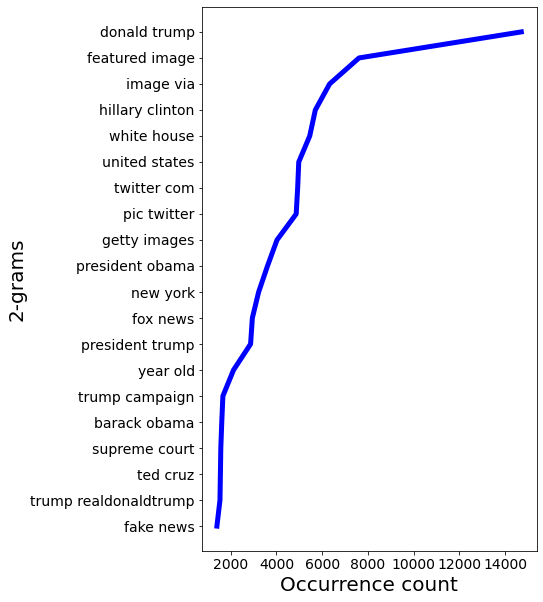

In [ ]:
b = get_ngrams(dataset[dataset['label']==0]['article_clean'],2,20)
plot_ngrams(b,"Bigram for Fake News", 2, num_to_show=20)

# 3. Model prediction

## 3.1. Data Preparation

In [ ]:
import torch
from torch import nn
import torch.optim as optim
import nltk
from nltk import word_tokenize
nltk.download('punkt')
from torch.nn.utils.rnn import pad_sequence
import random
from torch.utils.data import Dataset, DataLoader

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Firstly, we define a function to help us split our dataset into training, validation and testing datasets split between our cleaned articles and the labels

In [ ]:
def get_splits(x, y, splits):
  """
  Split the features and target variables into training, validation and testing datasets 
  ------
  Inputs : 
    x (pd.Serie) : cleaned articles 
    y (pd.Serie) : target variable
    splits (floats tuple) : proportion of training and validation samples 
  Outputs : 
    (train_x, train_y), (valid_x, valid_y), (test_x, test_y) (numpy arrays) : splitted datasets between training features and targets, validation features and targets, testing features and targets
  """
    # Create an index list and shuffle it
  n = len(x)
  indexes = np.arange(n)
  random.shuffle(indexes)

  # Find the two indexes we'll use to cut the lists from the splits
  valid_begin = int(splits[0]*n)
  test_begin = valid_begin + int(splits[1]*n)
  
  # We process the splitting using our defined indexes
  train_x, train_y = np.array(x)[indexes[:valid_begin]], np.array(y)[indexes[:valid_begin]]
  valid_x, valid_y = np.array(x)[indexes[valid_begin:test_begin]], np.array(y)[indexes[valid_begin:test_begin]]
  test_x, test_y = np.array(x)[indexes[test_begin:]], np.array(y)[indexes[test_begin:]]
  return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

In [ ]:
splits = (0.8, 0.1)
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = get_splits(dataset['article_clean'], dataset['label'], splits)
(len(train_x), len(train_y)), (len(valid_x), len(valid_y)), (len(test_x), len(test_y))

((30912, 30912), (3864, 3864), (3865, 3865))

In [ ]:
def distribution_data(corpus): 
  """
  Returns number of fake and true news in a given dataset
  ----
  Inputs : 
    corpus (array) : labels of our dataset
  Outputs : 
    distrib (pd.DataFrame) : number of true and fake news in the dataset 
  """
  nb_true = corpus.sum()
  nb_false = len(corpus) - nb_true
  distrib = pd.DataFrame(data = {'Number of samples': [nb_true, nb_false], 'Label':['True', 'False']})
  return distrib

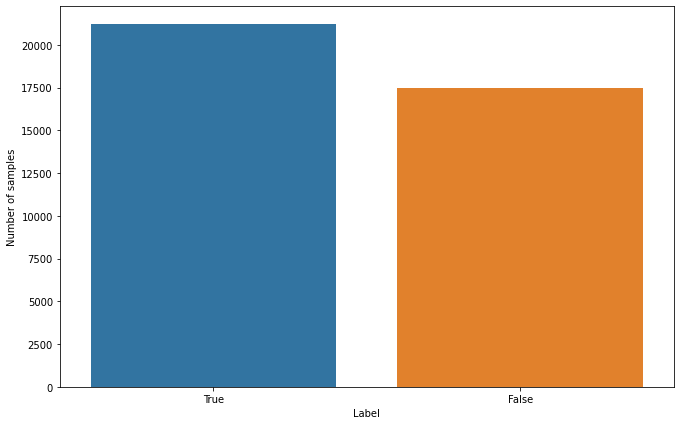

In [ ]:
distrib = distribution_data(dataset['label'])
fig, bar = plt.subplots(figsize = (11,7))
bar = sns.barplot(y='Number of samples', x='Label',data=distrib)

As we can see, our dataset is rather balanced between the number of fake and true news. Even if we note a larger presence of true news, fake news are not under represented thus preventing a bias of class for our model.

In [ ]:
train_distrib = distribution_data(train_y)
valid_distrib = distribution_data(valid_y)
test_distrib = distribution_data(test_y)

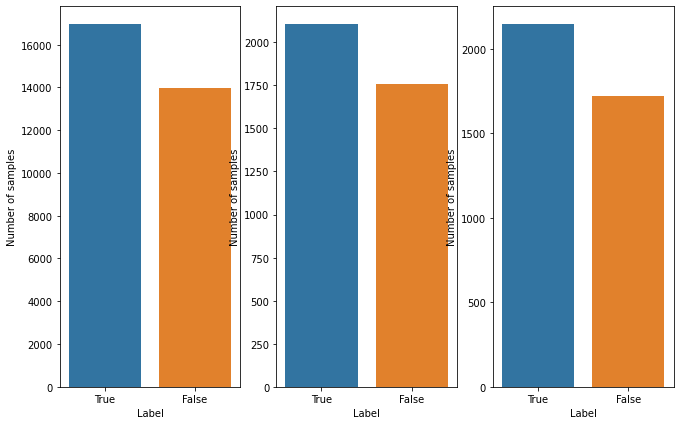

In [ ]:
fig, (bar1, bar2, bar3) = plt.subplots(1,3, figsize = (11,7))
sns.barplot(y='Number of samples', x='Label',data=train_distrib, ax = bar1)
sns.barplot(y='Number of samples', x='Label',data=valid_distrib, ax = bar2)
sns.barplot(y='Number of samples', x='Label',data=test_distrib, ax = bar3)

As we can see, the remark is still valid for our splitted datasets : we keep the same class represnetation in the train, validation and test datasets so that there is no bias. 

We then define a function inheriting the Dataset module from pytorch. This helps to build the vocabulary from our traning dataset and builds dictionnary from index to word and from word to index of this vocabulary. Then we process our cleaned articles with a few preliminary steps such as tokenizing using nltk, transpose the words of articles into indexes, pass them as tensor and only keep the determined length. Lastly, we pad the sequence to have uniform length across our samples. 

In [ ]:
class TextClassificationDataset(Dataset):
    def __init__(self, data, categories, vocab = None, max_length = 100, min_freq = 5):
        
        self.data = data
        self.max_length = max_length
        
        # Allow to import a vocabulary (validation and testing will use the training vocabulary)
        if vocab is not None:
            self.word2idx, self.idx2word = vocab
        else:
            # Build the vocabulary if none is imported
            self.word2idx, self.idx2word = self.build_vocab(self.data, min_freq)
        
        # We tokenize the articles
        tokenized_data = [word_tokenize(file.lower()) for file in self.data]
        # Transform words into lists of indexes
        indexed_data = [[self.word2idx.get(word, self.word2idx['UNK']) for word in file] for file in tokenized_data]
        # Transform into a list of Pytorch LongTensors
        tensor_data = [torch.LongTensor(file) for file in indexed_data]
        # Lables are passed into a FloatTensor
        tensor_y = torch.FloatTensor(categories)
        # Finally we cut too the determined maximum length
        cut_tensor_data = [tensor[:max_length] for tensor in tensor_data]
        # We pad the sequences to have the whole dataset containing sequences of the same length
        self.tensor_data = pad_sequence(cut_tensor_data, batch_first=True, padding_value=0)
        self.tensor_y = tensor_y
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        return self.tensor_data[idx], self.tensor_y[idx] 
    
    def build_vocab(self, corpus, count_threshold):
        word_counts = {}
        for sent in corpus:
            for word in word_tokenize(sent.lower()):
                if word not in word_counts:
                    word_counts[word] = 0
                word_counts[word] += 1   
        filtered_word_counts = {word: count for word, count in word_counts.items() if count >= count_threshold}        
        words = sorted(filtered_word_counts.keys(), key=word_counts.get, reverse=True) + ['UNK']
        word_index = {words[i] : (i+1) for i in range(len(words))}
        idx_word = {(i+1) : words[i] for i in range(len(words))}
        return word_index, idx_word
    
    def get_vocab(self):
        return self.word2idx, self.idx2word

Then we use our newly defined class to prepare the training data, build our vocabulary from the training dataset and then prepare our valisation and testing dataset. 

In [ ]:
training_dataset = TextClassificationDataset(train_x, train_y)
training_word2idx, training_idx2word = training_dataset.get_vocab()
valid_dataset = TextClassificationDataset(valid_x, valid_y, (training_word2idx, training_idx2word))
test_dataset = TextClassificationDataset(test_x, test_y, (training_word2idx, training_idx2word))

We then pass our datasets to DataLoader which combines a dataset and a sampler, and provides an iterable over the given dataset. This will shuffle the datasets and provide iterable object of batches. 



In [ ]:
training_dataloader = DataLoader(training_dataset, batch_size = 200, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size = 25)
test_dataloader = DataLoader(test_dataset, batch_size = 25)

## 3.2. Embeddings & Model Design

From gensim, we load a pretrained GloVe embedding with an embedding dimension of 300 features per word vector. This model has been trained on wikipedia.

In [ ]:
import gensim.downloader as api
loaded_glove_model = api.load("glove-wiki-gigaword-300")
loaded_glove_embeddings = loaded_glove_model.vectors

Next, we define a function that allows us to retrieve the vectors corresponding to each word in our vocabulary in a matrix : we first create a dictionnary with  our word index corresponding and retrieving the same word within GloVe's vocabulary. Then we create a dictionnary of the index of our word corresponding to the index of that word for GloVe and lastly we create our matrix retrieving the GloVe vectors. Lastly we apply this function and retrieve the GloVe embeddings of our loaded pretrained models for the words that constitute the vocabulary from our training dataset. 

In [ ]:
def get_glove_adapted_embeddings(glove_model, input_voc):
  """
  Retrieve a vocabulary words'embeddings from GloVe 
  ----
  Inputs : 
    glove_model () : GloVe Embedding model
    input_voc (dict) : dictionnary of our indexed vocabulary 
  Outputs : 
    embeddings (ndarray) : GloVe Embeddings for the given vocabulary with the vocabulary index
  """
  keys = {i: glove_model.vocab.get(w, None) for w, i in input_voc.items()}
  index_dict = {i: key.index for i, key in keys.items() if key is not None}
  embeddings = np.zeros((len(input_voc)+1,glove_model.vectors.shape[1]))
  for i, ind in index_dict.items():
      embeddings[i] = glove_model.vectors[ind]
  return embeddings

GloveEmbeddings = get_glove_adapted_embeddings(loaded_glove_model, training_word2idx)

Then we define our model. We decided to define a rather simple model for our task : after the embedding layer of dim (vocab_size, 300), we stack two LSTM layers with hidden_size of 256. We also enable to load our GloVe vectors as embeddings and the possibility to fine_tune those embedding on our data. Lastly, we have a fully connected layer. 

In [ ]:
class LSTMModel(nn.Module):

    def __init__(self, embedding_dim, vocabulary_size, hidden_dim, embeddings=None, fine_tuning=False):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        if embeddings:
            self.embeddings = nn.Embedding.from_pretrained(torch.FloatTensor(GloveEmbeddings), freeze=not fine_tuning, padding_idx=0)
        else:
            self.embeddings = nn.Embedding(num_embeddings=vocabulary_size+1, embedding_dim=embedding_dim, padding_idx=0)

        self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_dim, batch_first=True, num_layers=2)
        self.linear = nn.Linear(in_features=2*hidden_dim, out_features=1)

    def forward(self, inputs):
        emb = self.embeddings(inputs)
        lstm_out, (ht, ct) = self.lstm(emb, None)
        h = torch.cat((ht[-2], ht[-1]), dim=1)
        x = torch.squeeze(self.linear(h))
        return x

## 3.3. Training

### 3.3.1. Functions definition

We define a few functions first to help use with the training : 

*   <b><code>train_epochs</code></b> : iterates through the DataLoader object created with the training dataset and computes a pass (forward, loss, backward, weights update) on each batch of the DataLoader with metrics calculation.
*   <b><code>eval_model</code></b> : iterates through the DataLoader object created with the validation or testing dataset and computes a forward pass on each batch of the DataLoader with metrics calculation. 
*   <b><code>experiment</code></b> : iterates through the defined number of epochs (pass over whole data). For each one, we train thanks to the train_epoch function over the batches of the training datasets, at the end of each epoch, we evaluate on the validation dataset with eval_model and at the end of the training (all epochs done), evaluate on the test dataset. We store the loss, accuracy computations for all batches of all epochs for the training dataset, and for all epochs on the validation dataset. We don't store the accuraccy and loss computed on the test dataset but we keep the made predictions thanks to the test dataset.

In [ ]:
def train_epoch(model, opt, criterion, dataloader):
  """
  Trains the mode over an epoch 
  ----
  Inputs : 
    model () : defined model to be trained
    opt () : chosen and defined optimizer 
    criterion () : chosen and defined loss
    dataloader() : iterable object with the batches
  Outputs : 
    losses (list) : list of training loss for each batch of the epoch
    accs (list) : list of training accuracy for each batch of the epoch
  """
  model.train()
  losses = []
  accs = []
  for i, (x, y) in enumerate(dataloader):
      opt.zero_grad()
      # Forward pass
      pred = model(x)
      # Loss Computation
      loss = criterion(pred, y)
      # Backward pass
      loss.backward()
      # Weights update
      opt.step()
      losses.append(loss.item())
      # Compute accuracy
      num_corrects = sum((torch.sigmoid(pred)>0.5) == y)
      acc = 100.0 * num_corrects/len(y)
      accs.append(acc.item())
      if (i%20 == 0):
          print("Batch " + str(i) + " : training loss = " + str(loss.item()) + "; training acc = " + str(acc.item()))
  return losses, accs

In [ ]:
def eval_model(model, criterion, evalloader):
  """
  Evaluate the model  
  ----
  Inputs : 
    model () : defined model to be trained
    criterion () : chosen and defined loss
    evalloader() : iterable object with the batches 
  Outputs : 
    total_epoch_loss/(i+1) (float) : computed loss 
    total_epoch_acc/(i+1) (float) : computed accuracy 
    preds (list) : predictions made by the model
  """
  model.eval()
  total_epoch_loss = 0
  total_epoch_acc = 0
  preds = []
  with torch.no_grad():
      for i, (x, y) in enumerate(evalloader):
          pred = model(x)
          loss = criterion(pred, y)
          num_corrects = sum((torch.sigmoid(pred)>0.5) == y)
          acc = 100.0 * num_corrects/len(y)
          total_epoch_loss += loss.item()
          total_epoch_acc += acc.item()
          preds.append(pred)

  return total_epoch_loss/(i+1), total_epoch_acc/(i+1), preds

In [ ]:
def experiment(model, opt, criterion, num_epochs = 5):
  """
  Trains & Evaluates the model over all epochs 
  ----
  Inputs : 
    model () : defined model to be trained
    opt () : chosen and defined optimizer 
    criterion () : chosen and defined loss
    num_epochs() : chosen number of epochs to go through
  Outputs : 
    train_losses (list): training losses of all batches for each epochs
    valid_losses (list): losses over vaidation data for all epochs
    test_loss (list): loss over test data once the model is trained 
    train_accs (list): training accuracies of all batches for each epochs
    valid_accs (list): accuracies over vaidation data for all epochs
    test_acc (list): accuracy over test data once the model is trained
    test_preds (): predictions on test dataset
  """
  train_losses = []
  valid_losses = []
  train_accs = []
  valid_accs = []
  print("Beginning training...")
  for e in range(num_epochs):
      print("Epoch " + str(e+1) + ":")
      losses, accs = train_epoch(model, opt, criterion, training_dataloader)
      train_losses.append(losses)
      train_accs.append(accs)
      valid_loss, valid_acc, val_preds = eval_model(model, criterion, valid_dataloader)
      valid_losses.append(valid_loss)
      valid_accs.append(valid_acc)
      print("Epoch " + str(e+1) + " : Validation loss = " + str(valid_loss) + "; Validation acc = " + str(valid_acc))
  test_loss, test_acc, test_preds = eval_model(model, criterion, test_dataloader)
  print("Test loss = " + str(test_loss) + "; Test acc = " + str(test_acc))
  return train_losses, valid_losses, test_loss, train_accs, valid_accs, test_acc, test_preds

### 3.3.2. Training with the LSTM model 

Next we define our model and we choose an Adam optimizer whose parameters are detailed in the code below. Our loss, as the task is a binary classification is a binary cross entropy and we choose the <code> nn.BCEWithLogitsLoss() </code> which has a sigmoid step included. Next we train our model and display our accuracy and loss evolution over the 10 epochs

In [ ]:
EMBEDDING_DIM = 300 
VOCAB_SIZE = len(training_word2idx)
HIDDEN_DIM = 256
learning_rate = 0.0025
num_epochs = 10

In [ ]:
model_lstm = LSTMModel(EMBEDDING_DIM, VOCAB_SIZE, HIDDEN_DIM,  embeddings=True, fine_tuning=False)
opt = optim.Adam(model_lstm.parameters(), lr=learning_rate, betas=(0.9, 0.999))
criterion = nn.BCEWithLogitsLoss()

In [ ]:
train_losses_lstm, valid_losses_lstm, test_loss_lstm, train_accs_lstm, valid_accs_lstm, test_acc_lstm, test_preds_lstm = experiment(model_lstm, opt, criterion, num_epochs)

Beginning training...
Epoch 1:
Batch 0 : training loss = 0.6921212077140808; training acc = 55.0
Batch 20 : training loss = 0.38147473335266113; training acc = 87.5
Batch 40 : training loss = 0.26866480708122253; training acc = 91.0
Batch 60 : training loss = 0.534308910369873; training acc = 84.5
Batch 80 : training loss = 0.31614041328430176; training acc = 90.0
Batch 100 : training loss = 0.22194312512874603; training acc = 91.0
Batch 120 : training loss = 0.2760094702243805; training acc = 88.0
Batch 140 : training loss = 0.43993473052978516; training acc = 84.5
Epoch 1 : Validation loss = 0.2669369290913305; Validation acc = 91.40645161290323
Epoch 2:
Batch 0 : training loss = 0.27376243472099304; training acc = 90.5
Batch 20 : training loss = 0.19669857621192932; training acc = 95.0
Batch 40 : training loss = 0.6572098731994629; training acc = 68.0
Batch 60 : training loss = 0.4622701406478882; training acc = 76.5
Batch 80 : training loss = 0.2960137724876404; training acc = 90.5

In [ ]:
import statistics 
from statistics import mean
train_losses = [mean(train_loss) for train_loss in train_losses_lstm]
train_accs = [mean(train_acc) for train_acc in train_accs_lstm]

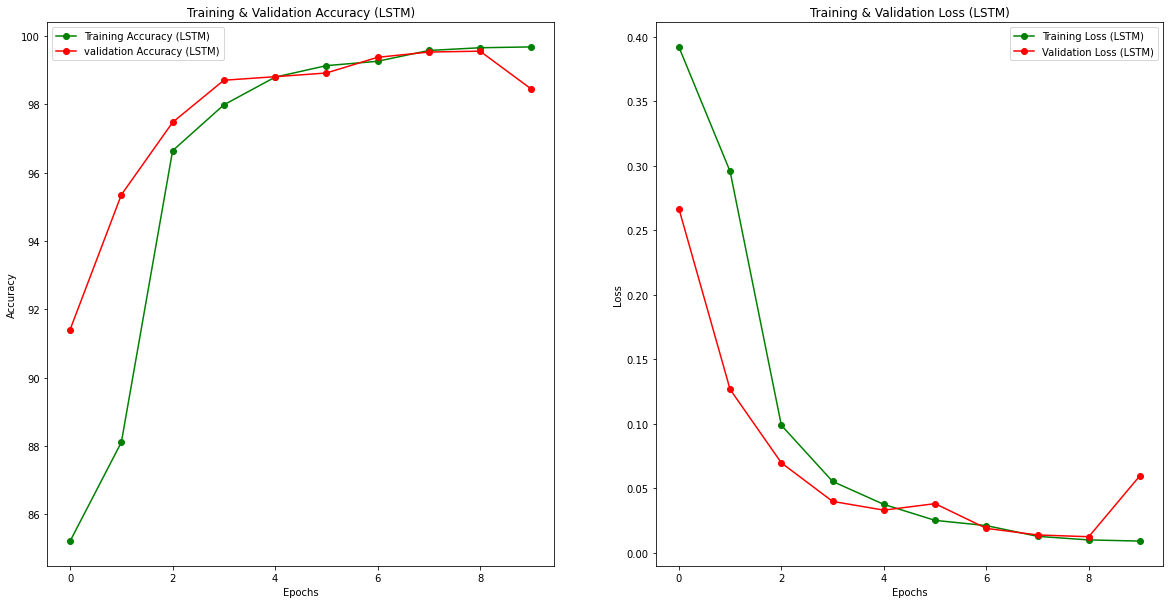

In [ ]:
epochs = [i for i in range(num_epochs)]
fig , ax = plt.subplots(1,2)
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_accs , 'go-' , label = 'Training Accuracy (LSTM)')
ax[0].plot(epochs , valid_accs_lstm , 'ro-' , label = 'validation Accuracy (LSTM)')
ax[0].set_title('Training & Validation Accuracy (LSTM)')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_losses , 'go-' , label = 'Training Loss (LSTM)')
ax[1].plot(epochs , valid_losses_lstm , 'ro-' , label = 'Validation Loss (LSTM)')
ax[1].set_title('Training & Validation Loss (LSTM)')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

### 3.3.3. Trying another model : CNN

Additionnally, even if we don't present it in the report, we tried to compare our first LSTM model with a CNN-based one which is define in the following cell. In this model we have an Embedding layer similar to the one used in our LSTM-based model with a size <code> (vocabulary_size, embedding_dim=300) </code>. 
Then we have a one-dimensional CNN layer with size <code>(embedding_size = 300, 64, 16) </code> with a ReLU activation function, then a max-pooling layer, a dropout layer with a parameter of dropout $0.5$ and a fully connected layer of size <code> (64, 1)</code>. 

In [ ]:
from torch.nn import functional as F

class CNNModel(nn.Module):
    def __init__(self, embedding_dim, vocabulary_size, window_size: int = 16, filter_multiplier = 64, embeddings = None, fine_tuning = False):
      super().__init__()
      self.embedding_dim = embedding_dim 
      if embeddings:
        self.embeddings = nn.Embedding.from_pretrained(torch.FloatTensor(GloveEmbeddings), freeze=not fine_tuning, padding_idx=0)

      else:
        self.embeddings = nn.Embedding(num_embeddings=vocabulary_size+1, embedding_dim=embedding_dim, padding_idx=0)

      self.conv1d = nn.Conv1d(embedding_dim, filter_multiplier, window_size)
      self.dropout = nn.Dropout(0.5)
      self.linear = nn.Linear(filter_multiplier, 1)

    def forward(self, inputs):
      x = self.embeddings(inputs)
      x = x.permute(0, 2, 1)
      x = self.conv1d(x)
      x = F.relu(x)
      x = F.max_pool1d(x, x.shape[2]).squeeze(2)
      x = self.dropout(x)
      output = torch.squeeze(self.linear(x))

      return output

We keep a similar Adam optimizer with parameters displayed below and the same Binary Cross Entropy Loss. 

In [ ]:
model_cnn = CNNModel(300, len(training_word2idx), 16, 64, embeddings = True, fine_tuning=True)
optimizer = optim.Adam(model_cnn.parameters(), lr=0.0025, betas=(0.9, 0.999))
criterion = nn.BCEWithLogitsLoss()

In [ ]:
train_losses_cnn, valid_losses_cnn, test_loss_cnn, train_accs_cnn, valid_accs_cnn, test_acc_cnn, test_preds_cnn = experiment(model_cnn, optimizer, criterion, num_epochs)

Beginning training...
Epoch 1:
Batch 0 : training loss = 0.7055560946464539; training acc = 50.5
Batch 20 : training loss = 0.1397164762020111; training acc = 93.0
Batch 40 : training loss = 0.10689283162355423; training acc = 96.5
Batch 60 : training loss = 0.044383298605680466; training acc = 99.0
Batch 80 : training loss = 0.035302966833114624; training acc = 99.0
Batch 100 : training loss = 0.0213660579174757; training acc = 100.0
Batch 120 : training loss = 0.055184505879879; training acc = 99.5
Batch 140 : training loss = 0.017045313492417336; training acc = 99.5
Epoch 1 : Validation loss = 0.02109063857952283; Validation acc = 99.35483870967742
Epoch 2:
Batch 0 : training loss = 0.005311382934451103; training acc = 100.0
Batch 20 : training loss = 0.003549431450664997; training acc = 100.0
Batch 40 : training loss = 0.0046349321492016315; training acc = 100.0
Batch 60 : training loss = 0.0029314178973436356; training acc = 100.0
Batch 80 : training loss = 0.0022185267880558968; 

In [ ]:
import statistics 
from statistics import mean
train_losses_cnn = [mean(train_loss) for train_loss in train_losses_cnn]
train_accs_cnn = [mean(train_acc) for train_acc in train_accs_cnn]

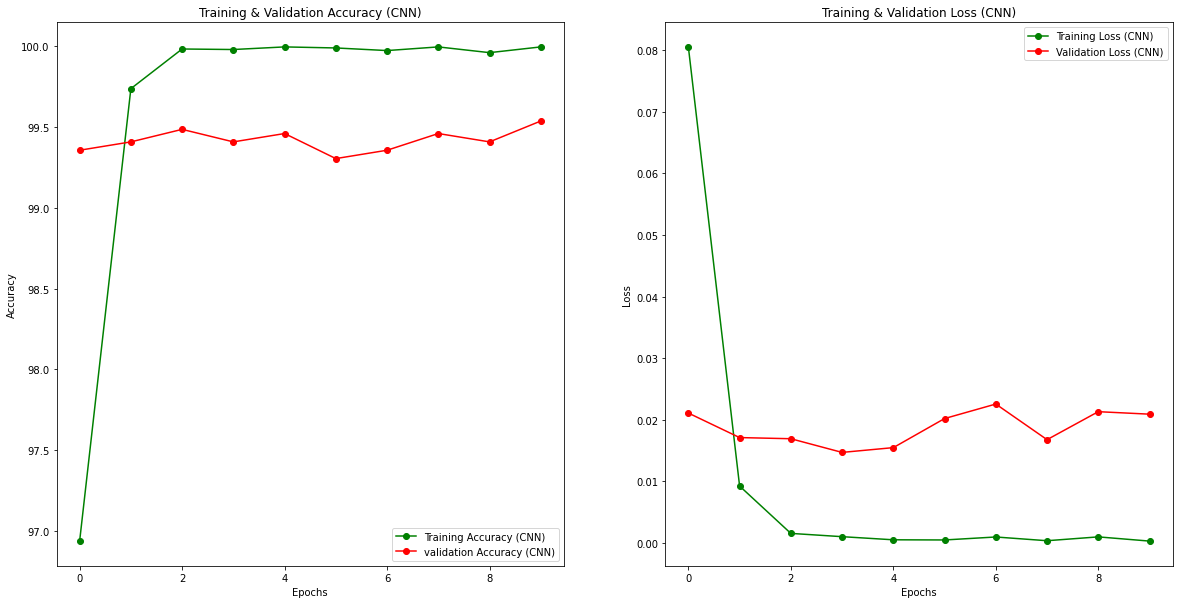

In [ ]:
epochs = [i for i in range(num_epochs)]
fig , ax = plt.subplots(1,2)
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_accs_cnn , 'go-' , label = 'Training Accuracy (CNN)')
ax[0].plot(epochs , valid_accs_cnn , 'ro-' , label = 'validation Accuracy (CNN)')
ax[0].set_title('Training & Validation Accuracy (CNN)')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_losses_cnn , 'go-' , label = 'Training Loss (CNN)')
ax[1].plot(epochs , valid_losses_cnn , 'ro-' , label = 'Validation Loss (CNN)')
ax[1].set_title('Training & Validation Loss (CNN)')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

It seems that our CNN-based model overfit (training accuracy significantly higher than the LSTM-based model and the loss significantly lower). Thus it seems that this model isn't well suited and we will continue with the Evaluation of our LSTM-based model.

# 3.4. Evaluation (LSTM Model)

To evaluate our model, we will begin by analysing the confusion matrix which enables to access a descriptive and comprehensive performance of our model i.e. to access True Positive, True Negative, False Positive an False Negative. 

In [ ]:
preds = [(torch.sigmoid(t)>0.5).tolist() for t in test_preds_lstm]
preds = [int(t) for el in preds for t in el]

We display a few ground truth 

In [ ]:
preds[:20]

[1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1]

In [ ]:
test_y[:20]

array([1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1])

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(preds,test_y)
cm_ = pd.DataFrame(cm , index = ['True','Fake'] , columns = ['True','Fake'])

Text(33.0, 0.5, 'Actual')

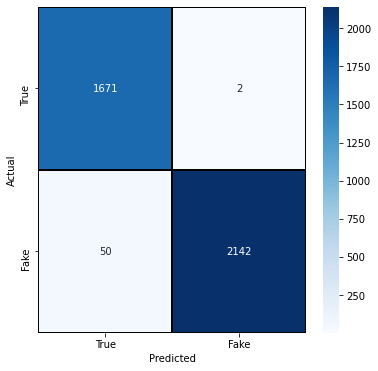

In [ ]:
plt.figure(figsize = (6,6))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['True','Fake'] , yticklabels = ['True','Fake'])
plt.xlabel("Predicted")
plt.ylabel("Actual")




*   **True Positives :** True News given as such by the model
*   **True Negative :** Fake News given as such by the model
*   **False Positive :** Fake News given as true by the model : dangerous as it can lead to a certified publication thus ensuring trust whereas it spread fake informations to the public. 
*   **False Negative :** True News given as Fake by the model. Can be seen as less problematic because it still prevents fake news from being spread out but still remain important for example in the eyesof a publisher it has to be low. 

As we could see with our accuraccy score, our model seems to perform rather well with an overall accuracy of 99.58%. Given that our data is rather balanced, accuracy an be used to evaluate our model overall. As we can see, only 16 of our test samples were misclassified. 

Accuracy gives a general idea of the performance of our model. However, depending on who and why the model is used, accuracy might not be the optimal metric to use. Indeed, in our case, as very few mistakes are made by the model, these options will be less important but are still valid. 

*  **Precision:** For example, in a context of political importance such as it was the case of the 2016 US election, the number of well-classifiednews is not what would matter the most for the political parties or institutions. Indeed, for the government or the candidates the most important is that no fake news are classified as positive and thus are published or diplayed to users (we can think for example about model deployed by social media twitter or Facebook). In that case, accuracy is not very helpful because we can still make important mistakes that are drown by the number of correct prediction. In that case we want the number of True Positive to be very high compared to samples classified as positive i.e. we want the precision to be high. High precision indicate that over all that is presented to the readers, most of news are true. An indicator could be to prioritize a 100% for precision but consequences can occur on the overall model performance and can lead to censorship (increase in false negatives as we increase the certainty treshold of having true positive).

* **Recall:** Another example could be a publisher who wants its articles to be published everytime. In that case the number of true positives has to be very high compared to true positives and false negatives number i.e. recall has to be high. 

*  **$F_\beta$-score:** F1-score is the harmonic mean of precision and recall and $F_\beta$-score applies additional weights, valuing one of precision or recall more than the other thus it can be interesting also to take into account both metrics. This can allow for betetr balanced still with either control towards recall or precision. 

To have a few more informations about this model we propose to plot the classification report and look at precision, recall and f1-score for Predicted True class. 


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(test_y, preds, target_names = ['Predicted Fake','Predicted True']))

                precision    recall  f1-score   support

Predicted Fake       1.00      0.97      0.98      1721
Predicted True       0.98      1.00      0.99      2144

      accuracy                           0.99      3865
     macro avg       0.99      0.99      0.99      3865
  weighted avg       0.99      0.99      0.99      3865



Quantitatively, we see that our model performs (even suspiciously well, see later) well.

As we can see with our model, even if precision is a bit higher than recall, it is difficult to see a real difference and thus application where the model would be more adapted or if we have to change the model if we have a specific task. 

This level of performance therefore raises question about our dataset. Indeed, our model is quiet simple and with our dataset we still manage to perform oustandingly whilst not over-fitting as the curves of accuracy and loss suggest. Therefore, it seems that even if we tried to clean the obvious signs of the news between either true or false, the two datasets seem still too heterogeneous thus being easily classified. Indeed, as we saw at the beginning, almost all true news were published in Reuters whereas fake news were collected from unreliable websites that were flagged by Politifact (a fact-checking organization in the USA) and Wikipedia. Thus the datasets seem to lack of robustness from sources and differences could became obvious for our model. 

**What solutions ?**

*  What could be interesting is to produce **adversarial examples** for our model with **computer generated fake news** (generative models of adversarial examples) for example to seee how our model responds, evaluate it with precision, recall, F1-score in addition to accuracy and try to improve it on one metrics depending on the task we would like to focus on (see above : more oriented toward control over what reader see (high precision) or prevent censorship (high recall) or a designed weighting of those ($F_\beta$). 
*  We could also try to homogenise our datasets by diversifying the sources of fake and true news

Lastly, we propose to inspect two misclassified sample of our test set to see if anything striking comes up. 

In [ ]:
compare =  pd.DataFrame({'Ground truth' : test_y, 'Predicted': preds})
index_fn = np.where(compare['Ground truth'] - compare['Predicted'] == 1)
index_fp = np.where(compare['Ground truth'] - compare['Predicted'] == -1)

In [ ]:
index_fn[0][0]

177

In [ ]:
print ("Example of a false negative : predicted as fake news whereas it is true : ")

print(dataset[dataset['article_clean']==test_x[index_fn[0][0]]]['article'].values)

Example of a false negative : predicted as fake news whereas it is true : 
['Women in male-dominated career fields watch a unique U.S. presidential campaign. Dr. Linda Liau works with the precision of a master, peering into a patient’s head with magnifying loupes as she removes a brain tumor. When Liau was called into an emergency room as a surgeon more than 20 years ago to help treat a car crash victim, another member of the medical team assumed she was a nurse. Even today, the 49-year-old neurosurgeon sometimes gets a surprised reaction from new patients who were expecting a man.  Such an assumption is common in career fields dominated by men. Neurosurgery, welding, venture capitalism, construction, film directing and the electrical trade - these are six jobs where U.S. women have made inroads but are still vastly outnumbered. And one position, U.S. president, has never been filled by a woman. With presumptive Democratic nominee Hillary Clinton seeking to become the first to break th

In [ ]:
print ("Example of a false positive : predicted as true news whereas it is fake : ")
dataset[dataset['article_clean']==test_x[index_fp[0][0]]]['article'].values

Example of a false positive : predicted as true news whereas it is fake : 


array(['“GREXIT”? GREEKS VOTE NO ON MORE AUSTERITY IN RETURN FOR RESCUE LOANS. A number of European politicians, including Jeroen Dijsselbloem, the top eurozone official, have said a  no  vote would jeopardize Greece s place in the 19-nation eurozone. Investors are also likely to believe a  no  win increases the chance of a so-called  Grexit , where Greece returns to its own old currency. ATHENS, Greece (AP)   Greeks overwhelmingly rejected creditors  demands for more austerity in return for rescue loans in a critical referendum Sunday, backing Prime Minister Alexis Tsipras, who insisted the vote would give him a stronger hand to reach a better deal.Tsipras gambled the future of his 5-month-old left-wing government on the vote. The opposition accused him of jeopardizing the country s membership in the 19-nation club that uses the euro and said a  yes  vote was about keeping the common currency.With 70 percent of the votes counted, the  no  side had more than 60 percent. The interior mi

As we can see the false negative example contains thrill-seeker words such as "femen activist", "sextremist" etc. even if we stil have "Reuters" which can presumably lead towards true news. On the contrary, the false positive example, despite having sensationnalist words at the beginning "Muslim Refugee sex attacks" is less striking afterwards. 

In the above comment, we try to **explain** the predictions and what can lead to a misclassification. However, as we are using a deep learning model which is a black-box, this qualitative try of explainability is limited as we are just looking and pressuming what could explain the misclassification. A further development would then be to expand our results and model evaluation with **explainability methods** such as Lime or SHAP values for local (example) explainability. It would thus give us quantitative results to interpret an example's classification. Partial Dependancy Plots or Global Surrogate models could also give us insights about our model. 

# 4. Conclusion 

Our model yields excellent results whatever problematic - control over what the reader sees (high precision) or prevent censorship (high recall) - is chosen. Although we did our best to avoid data leakage, the excellent results of our rather simple model raise concerns on the soundness of both the dataset and the resulting model. \\
To ensure that our model is robust it could be interesting to test our model against a more homogeneous dataset by diversifying the sources of fake and verified news or test it against computer generated fake news that are especially designed to fool our model (adversarial model). \\

Finally, having a look at a few misclassified examples - here is an extract of a false negative : 


 

> "Topless Femen activist tries to snatch Jesus statue from Vatican crib" \\


thrill-seeker words could influence the model to lean towards classifying a headline as fake whilst being true. \\
A further development would then be to expand our results and model evaluation with explainability methods such as Lime or SHAP values for local (example) explainability. It would thus give us quantitative results to interpret an example's classification. 